# Predicting Water Quality: Safe or Not Safe for Consumption  #

<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExZWgyMTlmdjk3aHFjejM0ZGp1ZjhlYnBjbGIwbjM2NGN4MnV0eTdvYiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/S1N2zUokK7jiM/giphy.gif" width = "600"/>

Source: https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExZWgyMTlmdjk3aHFjejM0ZGp1ZjhlYnBjbGIwbjM2NGN4MnV0eTdvYiZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/S1N2zUokK7jiM/giphy.gif

<font color='#808080'>

# Table of Contents:

## 1. [Introduction](#intro)
* ### 1.1. Why is water safety an important topic?
* ### 1.2. Background Information & Our Question
* ### 1.3. Dataset Being Used
  
## [2. Preliminary exploratory data analysis](#p2)
* ### 2.1. Loading the Data
* ### 2.2 Summarizing the Data

## 3. Methods
* ### 3.1. Conducting our Data Analysis
* ### 3.2 Visualizing the Results


</font>


## 1. Introduction: ##

### Why is Water Safety an Important Topic? ###

Water is essential to all those who call Earth their home, and access to safe drinking water is a major component of effective policy for health protection. Having safe drinking water helps prevent the spread of infectious diseases that could impact the health of local communities. According to the World Health Organization (2023), in 2022 alone, “115 million people collect[ed] untreated surface water from lakes, ponds, rivers and streams”. As such, these waters are far more prone to contaminants that may strike people with intense illnesses, like cholera, diarrhoea, dysentery, hepatitis A, typhoid and polio. Given that these unsafe water put hundreds of millions of people worldwide at risk, water safety is a serious health and development issue at a national, regional, and local level. Different levels of different contaminants found in drinking water can lead to safety issues, that in turn negatively impact the quality of life of those affected. Finding contaminants in water and determining if the amounts make it unfit for consumption is an important step to ensure drinking water remains safe for all who need it. 


### Background Information & Our Question ###

Given how large of a concern water safety, we ask the question: **can we construct a model that predicts and classifies whether a sample of water is safe to consume or not, given a set of measured contaminant levels?** To answer this question, we will be using some of the most commonly found pollutants in water as predictors for water quality, such as arsenic, bacteria, lead, nitrates, nitrites, and viruses (United States Environmental Protection Agency, 2015to check whether or not they make the water unsafe to drink. 

### Dataset Being Used ###

The dataset we are using was found on Kaggle (https://www.kaggle.com/datasets/mssmartypants/water-quality), and it provides information on different contaminants in water and their maximum concentration allowed to be present for the water to remain safe to use. With nearly 8000 observations, it contains 20 predictor variables (the 6 most common contaminants will be used for predictors in our model), and one binary response variable.

## 2. Preliminary exploratory data analysis  <a id=”p2″></a>
### 2.1. Loading the Data

As seen below, we can load the dataset using the read_csv function, given that it a .csv file. To load in the dataset, we are using a GitHub raw URL (which links to the dataset we downloaded from Kaggle and added into our github repository) to load it in.

In [1]:
library(tidyverse)
library(tidymodels)
url <- "https://raw.githubusercontent.com/zayan-sheikh/DSCI-G13-Project/main/data/waterQuality1.csv"
raw_data <- read_csv(url) |>
            mutate(is_safe = as_factor(is_safe))|>
            mutate(is_safe = fct_recode(is_safe, 'safe' = '1', 'not safe' = '0')) |>
            select(arsenic, bacteria, viruses, lead, nitrates, nitrites, is_safe)

head(raw_data)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

arsenic,bacteria,viruses,lead,nitrates,nitrites,is_safe
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.04,0.20,0.000,0.054,16.08,1.13,safe
0.01,0.65,0.650,0.100,2.01,1.93,safe
0.04,0.05,0.003,0.078,14.16,1.11,not safe
0.04,0.71,0.710,0.016,1.41,1.29,safe
0.03,0.13,0.001,0.117,6.74,1.11,safe
0.03,0.67,0.670,0.135,9.75,1.89,safe


In [13]:
raw_data |> 
distinct(is_safe)

is_safe
<fct>
safe
not safe
NA


*This is a glimpse at the first 6 rows of our dataset. There are 20 variables and one class variable which will be used as our predicting class. As mentioned, we will limit our predictor variables to the 6 most common contaminants. Our prediction will be based on the amount of different materials in water samples which will be used to predict water safety. Our two conclusions to our analysis on the dataset will be either safe or not safe.*

**NOTE:** This data is already tidy, as each column denotes a variable (either contaminant level or water safety), each row denotes an observation, and each cell denotes a value.

In the cell below, we will split our data into training data, and testing data.

In [10]:
set.seed(1)
water_split <- initial_split(raw_data, prop = 0.75, strata = is_safe)
water_train <- training(water_split)
water_test <- testing(water_split)

Now, it would be useful to summarize this data to get a sense of its distribution. One way to do this would be to find the mean of each predictor variable, and also the proportion of safe to unsafe water. The cleaned data frame is categorized into 2 categories by using group_by and summarize to identify whether the water is safe or not, and the number of safe and unsafe water observations is counted, as shown below:

In [3]:
water_wrangled <- water_train |>
                    pivot_longer(cols = arsenic:nitrites, names_to = "contaminant", values_to = "level")

water_means <- water_wrangled |> 
                     na.omit() |>
                     group_by(contaminant)|>
                     summarize(average_value = mean(level))

water_means

# Manipulating data to get number of observations for each class
water_train_table <- water_train |> 
                     na.omit() |>
                     group_by(is_safe)|>
                     summarize(count = n())

water_train_table


contaminant,average_value
<chr>,<dbl>
arsenic,0.1669618
bacteria,0.3188274
lead,0.0998000
nitrates,9.8916580
nitrites,1.3360567
viruses,0.3276570


is_safe,count
<fct>,<int>
not safe,5312
safe,683


We now have a sense of the average values for each predictor variable we are using, as well as the distribution of our response variable. *Note: there is not an equal amount of safe and unsafe water, therefore this dataset is imbalanced.* We can adjust our analysis later on to combat any issues that may arise from this.

Now, for a deeper understanding of our dataset, we can visually interpret the distribution of each predictor variable, as done below:

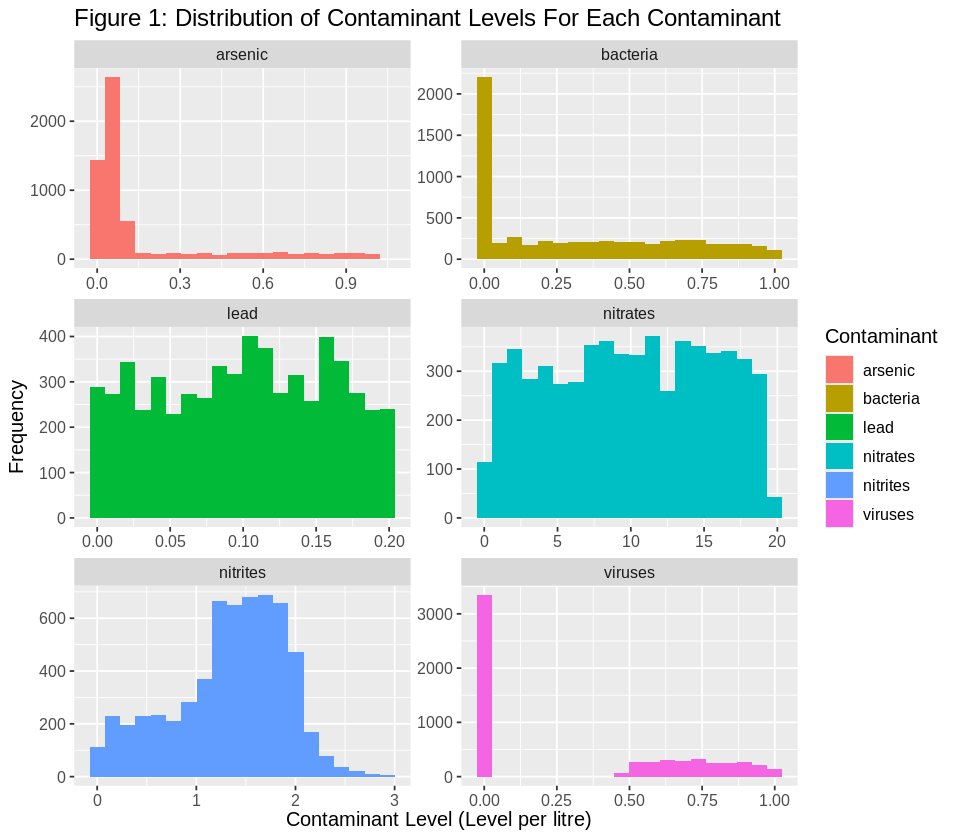

In [11]:
options(repr.plot.width = 8, repr.plot.height = 7)

water_train_plot <- water_wrangled |>
                    ggplot(aes(x=level, fill = contaminant)) +
                    geom_histogram(bins = 20) +
                    facet_wrap(vars(contaminant), scales = "free", nrow = 3) +
                    labs(x=" Contaminant Level (Level per litre)", y="Frequency", fill="Contaminant") +
                    ggtitle("Figure 1: Distribution of Contaminant Levels For Each Contaminant") +
                    theme(text = element_text(size = 12))
water_train_plot

*Figure 1 showcases one of many plots that can describe our situation. In this case, it shows the distribution of the various levels for each contaminant. The plotted histogram gives us a rough idea about the data we're working with; For instance, we can deduce that lead and nitrates have rather even distributions, whilst arsenic, bacteria, and viruses tend to have lower values in our dataset.*

*By summarizing and visualizing this data by count, we have now determined that this data is a good signal for classification, as there are some predictors that are concentrated in some areas, and some that are not concentrated in others, and as such, any new data can be predicted well due to the differences in the distribution between the predictors.*

***NOTE:*** *Each plot is on a different scale for readability, and was plotted using only the training data set.*

## 3. Methods  <a id=”3″></a> ##

### 3.1. Conducting our Data Analysis ###

To carry out this data analysis, we will be employing the k-nearest neighbors classification algorithm. This involves using the data on each existing observation's predictor values and whether or not the sample is safe to consume or not, and then using this data to "train our model," such that we can classify a new observation. Then, we will use our model to classify it using the predictors. To do this, we find the k-nearest data points, and then we simply choose whichever class the majority of the points have as our classification.

For our uses, 20 predictor variables is too high of a number, therefore, as mentioned earlier, we will limit our model to use the 6 most common contaminants in water: arsenic, bacteria, lead, nitrates, nitrites, and viruses, given in level per liter (United States Environmental Protection Agency, 2015). 

### 3.2. Visualizing the Results ###
One way in which we could visualize our results is by creating a scatterplot using our training data, choosing two predictors for the axes, and colouring the points according to class (safe or unsafe for consumption). From here, we can visually interpret how our k-nearest neighbors model classifies new observations, as well as simply seeing the spread of the data given two of the six predictor variables, seeing if there is any correlation between the two.


## 4. Expected outcomes and significance ##

Once our analysis is complete, we expect to have a working k-nearest neighbors model that can predict whether or not a water sample is safe, given the six predictor variables we have specified. We hope our findings can help find safe water sources around the world, and possibly also bring awareness to the public on the importance of how a safe water source can help limit the spread of gastrointestinal diseases and other related health issues, as well as inform people as to what contaminants they should be checking their water sources for.

Once we collect our results, this could lead to serveral future questions and expansions of this project. For example, given that our classifier operates on a binary (water is either safe or unsafe, no inbetween), one may question if there is any sort of measurement to be made regarding *how* safe water is to drink, to analyze if one water source is cleaner than another.

## References: ##
World Health Organization. (September, 2023). *Drinking-water*. World Health Organization. https://www.who.int/news-room/fact-sheets/detail/drinking-water 

United States Environmental Protection Agency. (2015, October). *Drinking water contaminants*. America’s Children and the Environment. https://www.epa.gov/sites/default/files/2015-10/documents/ace3_drinking_water.pdf 